In [1]:
import numpy as np
import tensorflow as tf
import keras as kr
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import seaborn as sns
import util
import importlib
importlib.reload(util)
import secrets
from keras.utils import load_img
kr.backend.clear_session()
import cv2 as cv2

2023-06-04 03:06:48.129400: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#READ CSV INTO DATAFRAME
HOME_DIR= "/storage1/fs1/pathaka/Active/lab/Jairaj/home/jairaj.mathur/X-Ray/"
IMG_DIR=  HOME_DIR+"archive/"
df_raw= pd.read_csv(HOME_DIR+'Data_Entry_2017.csv')
df_raw.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [3]:
df_raw.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'],
      dtype='object')

In [4]:
labels_raw= df_raw['Finding Labels']
labels_raw.value_counts()

No Finding                                                         60361
Infiltration                                                        9547
Atelectasis                                                         4215
Effusion                                                            3955
Nodule                                                              2705
                                                                   ...  
Atelectasis|Consolidation|Edema|Effusion|Infiltration|Pneumonia        1
Atelectasis|Consolidation|Effusion|Emphysema|Mass|Pneumothorax         1
Cardiomegaly|Effusion|Pleural_Thickening|Pneumothorax                  1
Edema|Infiltration|Pneumothorax                                        1
Atelectasis|Consolidation|Mass|Pleural_Thickening|Pneumothorax         1
Name: Finding Labels, Length: 836, dtype: int64

In [5]:
# Separate out individual labels
labels_processed= []
for label in labels_raw:
    labels_processed.append(label.split('|'))
labels_processed[:5]

[['Cardiomegaly'],
 ['Cardiomegaly', 'Emphysema'],
 ['Cardiomegaly', 'Effusion'],
 ['No Finding'],
 ['Hernia']]

In [6]:
unique_labels= set()
for label in labels_processed:
    for labs in label:
        unique_labels.add(labs)
unique_labels= list(unique_labels)
unique_labels

['Emphysema',
 'No Finding',
 'Consolidation',
 'Hernia',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Effusion',
 'Pneumonia',
 'Pneumothorax',
 'Fibrosis',
 'Edema',
 'Atelectasis',
 'Infiltration',
 'Cardiomegaly']

In [7]:
df= df_raw[['Image Index','Patient ID','Finding Labels']]
df.head()

,Image Index,Patient ID,Finding Labels
0,00000001_000.png,1,Cardiomegaly
1,00000001_001.png,1,Cardiomegaly|Emphysema
2,00000001_002.png,1,Cardiomegaly|Effusion
3,00000002_000.png,2,No Finding
4,00000003_000.png,3,Hernia


In [8]:
# Add image paths to dataframe
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join(IMG_DIR, 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', df.shape[0])

df['path'] = df['Image Index'].map(all_image_paths.get)
df.head()

Scans found: 112120 , Total Headers 112120


/tmp/866304.tmpdir/ipykernel_12/3787726247.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['path'] = df['Image Index'].map(all_image_paths.get)


,Image Index,Patient ID,Finding Labels,path
0,00000001_000.png,1,Cardiomegaly,/storage1/fs1/pathaka/Active/lab/Jairaj/home/j...
1,00000001_001.png,1,Cardiomegaly|Emphysema,/storage1/fs1/pathaka/Active/lab/Jairaj/home/j...
2,00000001_002.png,1,Cardiomegaly|Effusion,/storage1/fs1/pathaka/Active/lab/Jairaj/home/j...
3,00000002_000.png,2,No Finding,/storage1/fs1/pathaka/Active/lab/Jairaj/home/j...
4,00000003_000.png,3,Hernia,/storage1/fs1/pathaka/Active/lab/Jairaj/home/j...


In [9]:
# Check file dimensions
plt.imread(df.loc[0,'path']).shape # GREYSCALE

(1024, 1024)

In [10]:
#Create binary table for individual disease labels
for i, label in enumerate(labels_processed):
    for unq_lbl in unique_labels: # Set 1/0 for each unique label
        df.loc[i,unq_lbl]= 1 if unq_lbl in label else 0
df.head()

/tmp/866304.tmpdir/ipykernel_12/2833217125.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[i,unq_lbl]= 1 if unq_lbl in label else 0
/tmp/866304.tmpdir/ipykernel_12/2833217125.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[i,unq_lbl]= 1 if unq_lbl in label else 0
/tmp/866304.tmpdir/ipykernel_12/2833217125.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

,Image Index,Patient ID,Finding Labels,path,Emphysema,No Finding,Consolidation,Hernia,Mass,Nodule,Pleural_Thickening,Effusion,Pneumonia,Pneumothorax,Fibrosis,Edema,Atelectasis,Infiltration,Cardiomegaly
0,00000001_000.png,1,Cardiomegaly,/storage1/fs1/pathaka/Active/lab/Jairaj/home/j...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,00000001_001.png,1,Cardiomegaly|Emphysema,/storage1/fs1/pathaka/Active/lab/Jairaj/home/j...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,00000001_002.png,1,Cardiomegaly|Effusion,/storage1/fs1/pathaka/Active/lab/Jairaj/home/j...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,00000002_000.png,2,No Finding,/storage1/fs1/pathaka/Active/lab/Jairaj/home/j...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,3,Hernia,/storage1/fs1/pathaka/Active/lab/Jairaj/home/j...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df = df.drop(columns= 'No Finding')

In [12]:
#SPLIT FOR STRATIFICATION
unique_labels.remove('No Finding')
len(unique_labels)

14

In [13]:
train_df, valid_test_df = train_test_split(df, 
                                           test_size= 0.4, 
                                           random_state= 666
                                          )
valid_df, test_df= train_test_split(valid_test_df, 
                                   test_size= 0.5,
                                   random_state= 666)

In [14]:
len(train_df)

67272

In [15]:
def check_for_leakage(df1, df2, patient_col= 'Patient ID'):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """

    df1_patients_unique = set(df1[patient_col].values)
    df2_patients_unique = set(df2[patient_col].values)
    
    patients_in_both_groups = list(df1_patients_unique.intersection(df2_patients_unique))

    # leakage contains true if there is patient overlap, otherwise false.
    leakage = True if len(patients_in_both_groups) > 0 else False # boolean (true if there is at least 1 patient in both groups)
        
    return leakage

In [16]:
print("leakage between train and valid: {}".format(check_for_leakage(train_df, valid_df)))
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df)))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df)))

leakage between train and valid: True
leakage between train and test: True
leakage between valid and test: True


In [17]:
target_size= 224

In [18]:
# Get data generators for training, validation and testing
# Data generators help generate batches on the fly
# No need to load entire dataset in memory

from keras.preprocessing.image import ImageDataGenerator
pp_input= kr.applications.densenet.preprocess_input
#THIS WILL AUTOMATICALLY CONVERT GREYSCALE TO RGB
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=32, seed=666, target_w = target_size, target_h = target_size):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(preprocessing_function= pp_input)    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, 
                                 x_col, y_cols, train_size= len(train_df), 
                                 batch_size=512, seed=666, 
                                 target_w = target_size, target_h = target_size):
    """
    Return generator for validation set and test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting test and valid generators...")
    image_generator = ImageDataGenerator(preprocessing_function= pp_input)

    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [19]:
# Get generators for training and validation
train_generator = get_train_generator(train_df, None, "path", unique_labels)

valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, None, "path", unique_labels)

getting train generator...
Found 67272 validated image filenames.
getting test and valid generators...
Found 22424 validated image filenames.
Found 22424 validated image filenames.


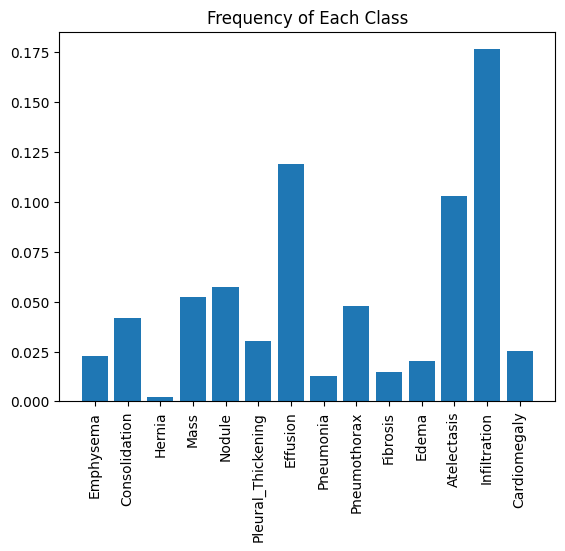

In [20]:
# Plot frequency distribution for each disease label in the training dataset
plt.xticks(rotation=90)
plt.bar(x=unique_labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [21]:
# Generate positive and negative frequency associated with each label
# Idea is to give more weight to the classes with lesser traning data,
# to balance out the loss 
labels= train_generator.labels
N = labels.shape[0]
freq_pos = (np.sum(labels, axis=0))/N
freq_neg = 1 - freq_pos

/tmp/866304.tmpdir/ipykernel_12/1940845047.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": unique_labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)


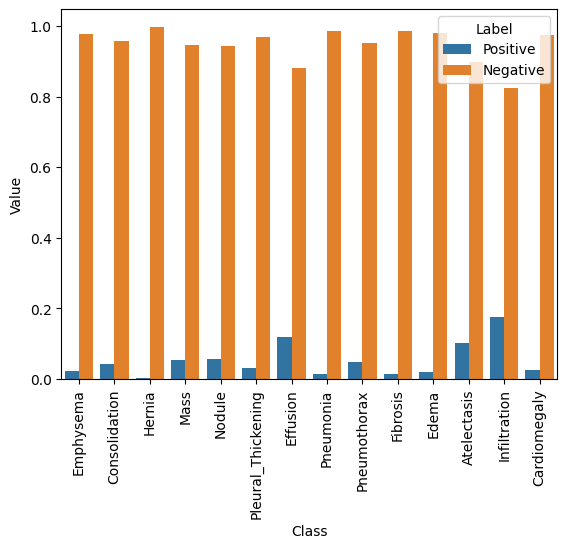

In [22]:
data = pd.DataFrame({"Class": unique_labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": unique_labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
# YOU ARE APPENDING THE VALUES ONE AT A TIME, FOR EACH LABEL AND THE CORRESPONDING NEGATIVE FREQUENCY
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [23]:
# Create a function to create loss function, 
# based on positive and negative frequency

def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        

        for i in range(len(pos_weights)):
            # for each class, add average weighted LOSS FOR THAT PARTICULAR CLASS, COZ YOU ARE LOOPING, NOT VECTORIZING
            loss += kr.backend.mean((-pos_weights[i]*tf.multiply(y_true[:,i], kr.backend.log(y_pred[:,i]+epsilon))- 
                                             neg_weights[i]*tf.multiply(1-y_true[:,i], kr.backend.log(1-y_pred[:,i]+epsilon) )) ) #complete this line
        return loss
    
    return weighted_loss

In [24]:
def net_model(image_size):
    IMAGE_SHAPE= (image_size +(3,))
    base_model= kr.applications.densenet.DenseNet121(
        include_top=False, weights= 'imagenet', input_shape=IMAGE_SHAPE)
    inputs= kr.Input(shape=IMAGE_SHAPE)
    x= base_model(inputs)

#     out1= kr.layers.Flatten()(x)
    out1= kr.layers.GlobalAveragePooling2D()(x)
#     out3= kr.layers.GlobalMaxPool2D()(x)
    
#     out= kr.layers.Concatenate(axis=-1)([out1, out2, out3])
#     out= kr.layers.Dropout(0.2)(out)
    
    output= kr.layers.Dense(len(unique_labels), activation= 'sigmoid')(out1)
    model= kr.Model(inputs, output)
    
    return model

In [25]:
model = net_model((target_size,target_size))

2023-06-04 03:11:37.185905: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10309 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:18:00.0, compute capability: 7.0


In [26]:
# Compile model with custom loss function with weights
pos_weights = freq_neg
neg_weights = freq_pos
model.compile(optimizer=kr.optimizers.Adam(learning_rate=0.001),
              loss=get_weighted_loss(pos_weights, neg_weights))

In [27]:
rand= secrets.randbelow(1000)
filepath = "best"+str(rand)+".hdf5"

checkpoint_loss = kr.callbacks.ModelCheckpoint(filepath="loss-"+filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True)

redLR= kr.callbacks.ReduceLROnPlateau(monitor="val_loss", factor= 0.5,
                                      patience= 1, verbose=1, min_lr= 0.001*(0.5**6))


calls= [redLR, checkpoint_loss]

In [28]:
history = model.fit(train_generator,
                    validation_data= valid_generator,
                    epochs= 10,
                    workers= 8,callbacks= calls)

Epoch 1/10


2023-06-04 03:11:43.071111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-04 03:11:57.288684: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-04 03:11:58.885359: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


2103/2103 [==============================] - ETA: 0s - loss: 0.8131

2023-06-04 03:21:42.783742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-04 03:21:54.283246: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-06-04 03:21:54.500289: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-06-04 03:21:55.666893: W tensorflow/tsl/framework/bfc_allocator


Epoch 1: val_loss improved from inf to 0.89444, saving model to loss-best678.hdf5
2103/2103 [==============================] - 724s 326ms/step - loss: 0.8131 - val_loss: 0.8944 - lr: 0.0010
Epoch 2/10
2103/2103 [==============================] - ETA: 0s - loss: 0.7668
Epoch 2: val_loss improved from 0.89444 to 0.77045, saving model to loss-best678.hdf5
2103/2103 [==============================] - 623s 296ms/step - loss: 0.7668 - val_loss: 0.7704 - lr: 0.0010
Epoch 3/10
2103/2103 [==============================] - ETA: 0s - loss: 0.7470
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 3: val_loss did not improve from 0.77045
2103/2103 [==============================] - 637s 302ms/step - loss: 0.7470 - val_loss: 0.8299 - lr: 0.0010
Epoch 4/10
2103/2103 [==============================] - ETA: 0s - loss: 0.7085
Epoch 4: val_loss improved from 0.77045 to 0.73851, saving model to loss-best678.hdf5
2103/2103 [==============================] - 637s 302ms/step

In [29]:
model= kr.models.load_model("loss-best"+str(rand)+".hdf5", custom_objects={ 'weighted_loss': get_weighted_loss(pos_weights, neg_weights) })
# model= kr.models.load_model("loss-best"+str(695)+".hdf5", custom_objects={ 'weighted_loss': get_weighted_loss(pos_weights, neg_weights) })

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 14)                14350     
                                                                 
Total params: 7,051,854
Trainable params: 6,968,206
Non-trainable params: 83,648
_________________________________________________________________


In [31]:
predicted_vals = model.predict(test_generator, workers=16)

2023-06-04 04:58:44.216344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


44/44 [==============================] - 136s 3s/step


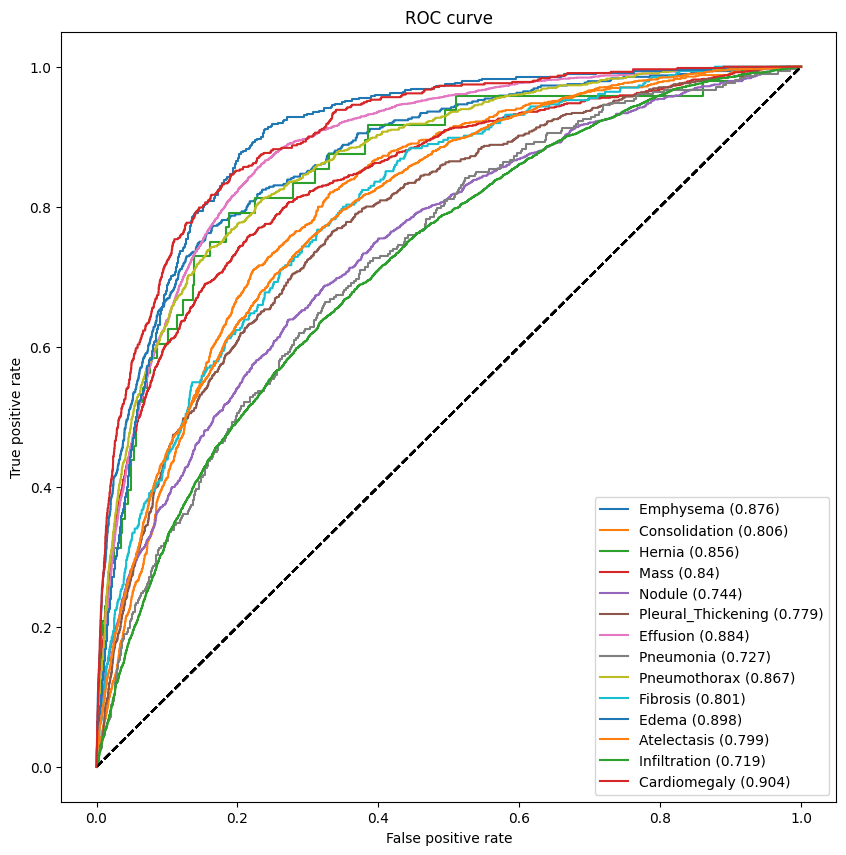

In [32]:
auc_rocs = util.get_roc_curve(unique_labels, predicted_vals, test_generator) #THIS LABELS IS SOMETHING ELSE, ACTUAL NAMES OF THE LABELS IN THESAME ORDER

In [33]:
# Top diseases with highest AUC
labels_to_show = np.take(unique_labels, np.argsort(auc_rocs)[::-1])[:3] #TOP 3 PREDICTIVE CLASSES
labels_to_show

array(['Cardiomegaly', 'Edema', 'Effusion'], dtype='<U18')

In [34]:
# Define helper functions to load, preprocess and compute gradCam
def load_image(img, image_dir, df, preprocess=True, H=224, W=224):
    """Load and preprocess image."""
    x = load_img(img, target_size=(H, W))#BECAUSE WE HAVE THE NAMES DIRECTLY
    if preprocess:
        x= pp_input(np.array(x))
        x= np.expand_dims(x, axis=0)
    return x


def compute_gradcam(model, img, image_dir, df, labels, selected_labels,
                    layer_name='densenet121'):
    
    preprocessed_input = load_image(img, image_dir, df, H=224, W=224)
    predictions = model.predict(preprocessed_input)
    print("Loading original image")
    plt.figure(figsize=(15, 10))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img, image_dir, df, preprocess=False), cmap='gray')

    j = 1
    for i in range(len(labels)):
        if labels[i] in selected_labels:
            print(f"Generating gradcam for class {labels[i]}")
            gradcam = grad_cam(preprocessed_input, model, layer_name, pred_index=i, H=224, W=224)
            plt.subplot(151+j)
            plt.title(f"{labels[i]}: p={predictions[0][i]:.3f}")
            plt.axis('off')
            plt.imshow(load_image(img, image_dir, df, preprocess=False, H=224, W=224),
                       cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[0][i]))
            j += 1


In [35]:
def grad_cam(img_array, model, last_conv_layer_name,  pred_index=i, H=224, W=224):
    """GradCAM method for visualizing input saliency."""
    grad_model= kr.Model(model.inputs,
             [model.get_layer('global_average_pooling2d').input, 
              model.output])

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        convOutputs, pred = grad_model(img_array)
        loss = pred[:,pred_index]
    grads = tape.gradient(loss, convOutputs)           
    # use automatic differentiation to compute the gradients
    
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads  
    # compute the guided gradients
    
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    heatmap = cv2.resize(cam.numpy(), (H,W))
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + 0.0001  # normalize the heatmap such that all values lie in the range
    heatmap = numer / denom                            # [0, 1], scale the resulting values to the range [0, 255]
    heatmap = (heatmap * 255).astype("uint8")          # and then convert to an unsigned 8-bit integer
    return heatmap

1/1 [==============================] - 8s 8s/step
Loading original image
Generating gradcam for class Effusion
Generating gradcam for class Edema
Generating gradcam for class Cardiomegaly


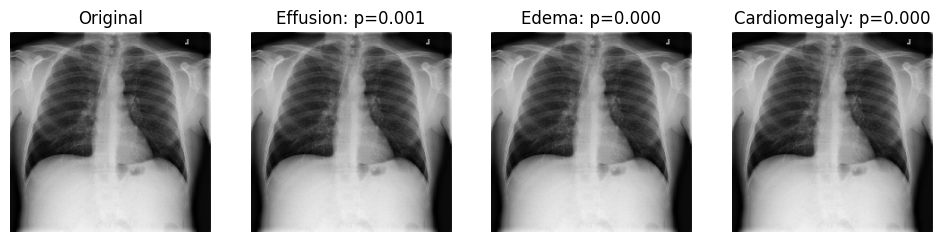

In [36]:
compute_gradcam(model, df['path'][31633], IMG_DIR, df, unique_labels, labels_to_show)

1/1 [==============================] - 0s 33ms/step
Loading original image
Generating gradcam for class Effusion
Generating gradcam for class Edema
Generating gradcam for class Cardiomegaly


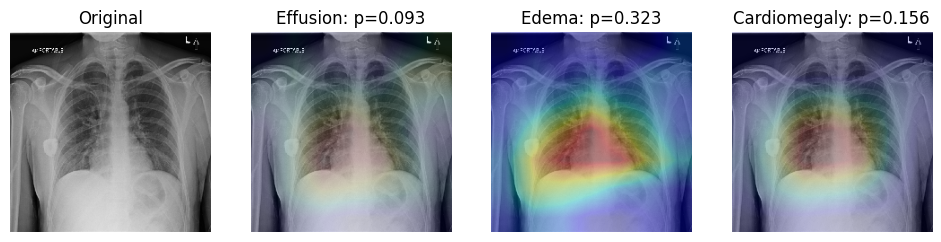

In [37]:
compute_gradcam(model, df['path'][109688], IMG_DIR, df, unique_labels, labels_to_show)

1/1 [==============================] - 0s 34ms/step
Loading original image
Generating gradcam for class Effusion
Generating gradcam for class Edema
Generating gradcam for class Cardiomegaly


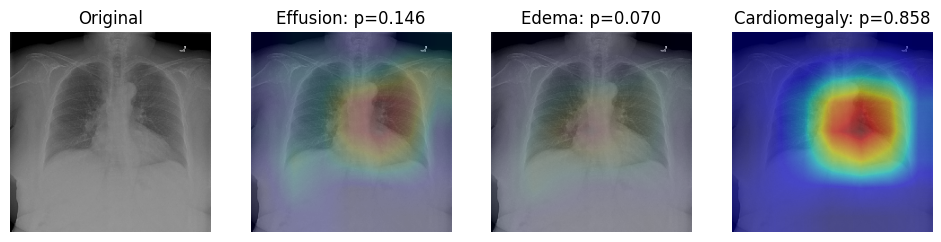

In [38]:
compute_gradcam(model, df['path'][111764], IMG_DIR, df, unique_labels, labels_to_show)

1/1 [==============================] - 0s 32ms/step
Loading original image
Generating gradcam for class Effusion
Generating gradcam for class Edema
Generating gradcam for class Cardiomegaly


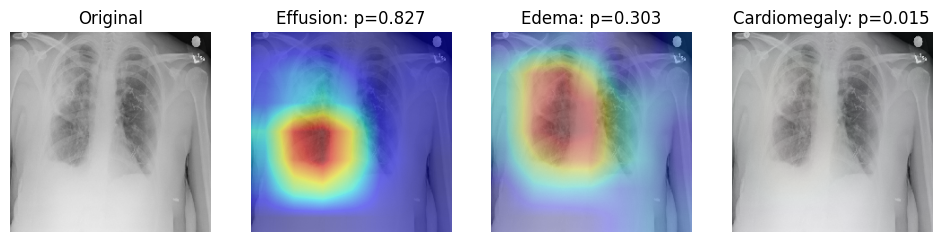

In [39]:
compute_gradcam(model, df['path'][7657], IMG_DIR, df, unique_labels, labels_to_show)

In [40]:
# df[df['Image Index']=='00011355_002.png']

# df['Finding Labels'][31633]

# pd.set_option('display.max_rows', None)

# df[df['Finding Labels']=='Effusion']

# df['Finding Labels'][44001]
# df['Finding Labels'].map(lambda x: x[:4])


In [41]:
df['path'][1000]

'/storage1/fs1/pathaka/Active/lab/Jairaj/home/jairaj.mathur/X-Ray/archive/images_001/images/00000246_018.png'

In [42]:
df['Image Index'][1000]

'00000246_018.png'